# Prediction of number of deaths/infected through COVID-19

This predictions are done on 26/04/2020, using data until this date.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from datetime import datetime,timedelta

## Data

The data comes from here: https://github.com/CSSEGISandData/COVID-19/

In [2]:
df_recovered=pd.read_csv('COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
df_recovered.head()


,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,54,99,112,131,135,150,166,179,188,188
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,277,283,302,314,327,345,356,385,394,403
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,783,846,894,1047,1099,1152,1204,1355,1408,1479
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,169,191,205,235,248,282,309,333,344,344
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,5,5,6,6,6,6,6,6,6,6


In [3]:
df_confirmed=pd.read_csv('COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
df_confirmed.head()


,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,840,906,933,996,1026,1092,1176,1279,1351,1463
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,518,539,548,562,584,609,634,663,678,712
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,2268,2418,2534,2629,2718,2811,2910,3007,3127,3256
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,673,696,704,713,717,717,723,723,731,738
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,19,19,24,24,24,24,25,25,25,25


In [4]:
df_dead=pd.read_csv('COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
df_dead.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,30,30,30,33,36,36,40,42,43,47
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,26,26,26,26,26,26,27,27,27,27
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,348,364,367,375,384,392,402,407,415,419
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,33,35,35,36,37,37,37,37,40,40
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,2,2,2,2,2,2,2,2,2,2


## Data manipulation

So far, I pick up five different countries to study:

- China (The first one, and therefore the reference to compare to).
- Italy (One of the biggest ones, and much more similar in social, politics and size with other Europen countries).
- Spain
- France
- US (Summing all the data from all the states together).

In [5]:
df_confirmed.loc['WholeUS'] = df_confirmed[df_confirmed['Country/Region']=='US'].sum()
df_confirmed.loc[df_confirmed.index=='WholeUS','Country/Region']='WholeUS'
df_dead.loc['WholeUS'] = df_dead[df_dead['Country/Region']=='US'].sum()
df_dead.loc[df_dead.index=='WholeUS','Country/Region']='WholeUS'

In [6]:
df_confirmed.loc[df_confirmed.index=='WholeUS',:]

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20
WholeUS,0,WholeUS,37.0902,-95.7129,1,1,2,2,5,5,...,667592,699706,732197,758809,784326,811865,840351,869170,905358,938154


In [7]:
df_confirmed[(df_confirmed['Country/Region']=='France') & (df_confirmed['Province/State'].isnull())]

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20
116,NaN,France,46.2276,2.2137,0,0,2,3,3,3,...,144944,146923,146906,151808,154188,156921,154715,157026,158636,160292


In [8]:
def select_countries(df):
    df = df[(df['Country/Region']=='Spain') | (df['Country/Region']=='Italy') | 
                            ((df['Country/Region']=='France') & (df['Province/State'].isnull()))
                            |((df['Country/Region']=='China') & (df['Province/State']=='Hubei')) |
           (df['Country/Region']=='WholeUS')]
    return df

In [9]:
def prepare_dataframe(df,label='contagious'):
    """
    I create a new column "DayStart"+Country, which sets to 1 the day the number of contagious or deads equal the same as China on 1/22/20.
    This is done to be able to compare past curves (such as in China or Italy), with present ones (France, Spain or US)
    """
    if label=='contagious':
        nspain=43
        nfrance=42
        nitaly=34
        nus=44
    if label=='death':
        nspain=43
        nfrance=44
        nitaly=35
        nus=44
        
    df = df.set_index('Country/Region').drop(['Lat','Long','Province/State'],axis=1).T
    df = df.reset_index()
    df['DayStartChina']= df.index +1
    df['DayStartSpain']= df.index -nspain
    df['DayStartFrance']= df.index -nfrance
    df['DayStartItaly']= df.index -nitaly
    df['DayStartUS']= df.index -nus
    
    return df
        

In [10]:
df_contag  = select_countries(df_confirmed)
df_death  = select_countries(df_dead)

In [11]:
df_contag  = prepare_dataframe(df_contag,label='contagious')
df_death  = prepare_dataframe(df_death,label='death')

In [12]:
df_contag.head()

Country/Region,index,China,France,Italy,Spain,WholeUS,DayStartChina,DayStartSpain,DayStartFrance,DayStartItaly,DayStartUS
0,1/22/20,444,0,0,0,1,1,-43,-42,-34,-44
1,1/23/20,444,0,0,0,1,2,-42,-41,-33,-43
2,1/24/20,549,2,0,0,2,3,-41,-40,-32,-42
3,1/25/20,761,3,0,0,2,4,-40,-39,-31,-41
4,1/26/20,1058,3,0,0,5,5,-39,-38,-30,-40


## Model the data

As this is a Pandemic, we know it grows as an Exponential, until it reaches the inflexion point and it becomes a logistic function. I'm then going to consider both models for our analysis. 

In [13]:
def exponential_model(x,a,b,c):
    return a*np.exp(b*(x-c))

def logistic_model(x,a,b,c):
    return c/(1+np.exp(-(x-b)/a))


In [14]:
def plot_normalized_day0(df,label='Contagious',fit=True):
    
    fig = plt.figure(figsize=(10,12))
    ax = fig.add_subplot(1, 1, 1)

    
    plt.plot(df['DayStartSpain'][df['DayStartSpain']>0],df['Spain'][df['DayStartSpain']>0],'b*')
    plt.plot(df['DayStartFrance'][df['DayStartFrance']>0],df['France'][df['DayStartFrance']>0],'yo')
    plt.plot(df['DayStartUS'][df['DayStartUS']>0],df['WholeUS'][df['DayStartUS']>0],'ms')
    plt.plot(df['DayStartItaly'][df['DayStartItaly']>0],df['Italy'][df['DayStartItaly']>0],'gv')
    plt.plot(df['DayStartChina'],df['China'],'r+')

    print('Last amount:')
    print('Spain ',df['Spain'].iloc[-1])
    print('France ',df['France'].iloc[-1])
    print('US ',df['WholeUS'].iloc[-1])
    print('Italy ',df['Italy'].iloc[-1])
    print('China ',df['China'].iloc[-1])

    if fit:
        xxS = np.array(df['DayStartSpain'][df['DayStartSpain']>0])
        yyS = np.array(df['Spain'][df['DayStartSpain']>0])
        xxSi=xxS[xxS<20]
        yySi=yyS[xxS<20]
        popt, pcov = curve_fit(exponential_model, xxSi, yySi, bounds=([-100,-1.,-100], [100., 1., 100.]))        
        poptS, pcovS = curve_fit(logistic_model, xxS, yyS, bounds=([1,10.,100], [10., 100., 1000000.]))
        plt.plot(xxSi, exponential_model(xxSi, *popt), 'b-')#
        plt.plot(xxS, logistic_model(xxS, *poptS), 'b--')#
        print('Spain Exponential fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
        print('Spain Logistic fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(poptS))

        xxF = np.array(df['DayStartFrance'][df['DayStartFrance']>0])
        yyF = np.array(df['France'][df['DayStartFrance']>0])
        xxFi=xxF[xxF<22]
        yyFi=yyF[xxF<22]
        popt, pcov = curve_fit(exponential_model, xxF, yyF, bounds=([-100,-1.,-100], [100., 1., 100.]))
        plt.plot(xxFi, exponential_model(xxFi, *popt), 'y-')#
        poptF, pcovF = curve_fit(logistic_model, xxF, yyF, bounds=([1,10.,100], [10., 100., 1000000.]))
        plt.plot(xxF, logistic_model(xxF, *poptF), 'y--')#
        print('France Exponential fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
        print('France Logistic fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(poptF))

        xxW = np.array(df['DayStartUS'][df['DayStartUS']>0])
        yyW = np.array(df['WholeUS'][df['DayStartUS']>0])
        xxWi=xxW[xxW<20]
        yyWi=yyW[xxW<20]        
        popt, pcov = curve_fit(exponential_model, xxWi, yyWi, bounds=([-100,-1.,-100], [100., 1., 100.]))
        plt.plot(xxWi, exponential_model(xxWi, *popt), 'm-')#
        poptW, pcovW = curve_fit(logistic_model, xxW, yyW, bounds=([1,10.,100], [10., 100., 1000000.]))
        plt.plot(xxW, logistic_model(xxW, *poptW), 'm--')#
        print('US Exponential fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
        print('US Logistic fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(poptW))

        xxI = np.array(df['DayStartItaly'][df['DayStartItaly']>0])
        yyI = np.array(df['Italy'][df['DayStartItaly']>0])
        xxIi=xxI[xxI<20]
        yyIi=yyI[xxI<20]
        popt, pcov = curve_fit(exponential_model, xxIi, yyIi) 
        plt.plot(xxIi, exponential_model(xxIi, *popt), 'g-')
        poptI, pcovI = curve_fit(logistic_model, xxI, yyI, bounds=([1,10.,100], [10., 100., 1000000.]))
        plt.plot(xxI, logistic_model(xxI, *poptI), 'g--')#
        print('Italy Exponential fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
        print('Italy Logistic fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(poptI))

        xxC = np.array(df['DayStartChina'])
        yyC = np.array(df['China'])
        xxCi=xxC[xxC<20]
        yyCi=yyC[xxC<20]
        popt, pcov = curve_fit(exponential_model, xxCi, yyCi) 
        plt.plot(xxCi, exponential_model(xxCi, *popt), 'r-')
        poptC, pcovC = curve_fit(logistic_model, xxC, yyC, bounds=([1,10.,100], [10., 100., 1000000.]))
        plt.plot(xxC, logistic_model(xxC, *poptC), 'r--')#
        print('China Exponential fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
        print('China Logistic fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(poptC))

    ax.set_yscale('log')
    plt.xticks(rotation=45)
    plt.legend(['Spain','France','US','Italy','China','Spain Exponential Model','Spain Logistic Model',
                'France Exponential Model','France Logistic Model','US Exponential Model','US Logistic Model',
            'Italy Exponential Model', 'Italy Logistic Model','China Exponential Model', 'China Logistic Model'])
    plt.xlabel('Day from start of multiple '+label)
    plt.ylabel('N '+label)
    plt.show()

Last amount:
Spain  223759
France  160292
US  938154
Italy  195351
China  68128
Spain Exponential fit: a=20.794, b=0.187, c=-21.683
Spain Logistic fit: a=6.745, b=28.339, c=215676.039
France Exponential fit: a=80.056, b=0.056, c=-88.070
France Logistic fit: a=7.600, b=35.327, c=183972.313
US Exponential fit: a=17.300, b=0.263, c=-12.551
US Logistic fit: a=6.865, b=35.341, c=996198.261
Italy Exponential fit: a=12.334, b=0.185, c=-22.123
Italy Logistic fit: a=8.253, b=33.889, c=193772.234
China Exponential fit: a=23.779, b=0.170, c=-23.587
China Logistic fit: a=4.271, b=19.708, c=67816.408


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


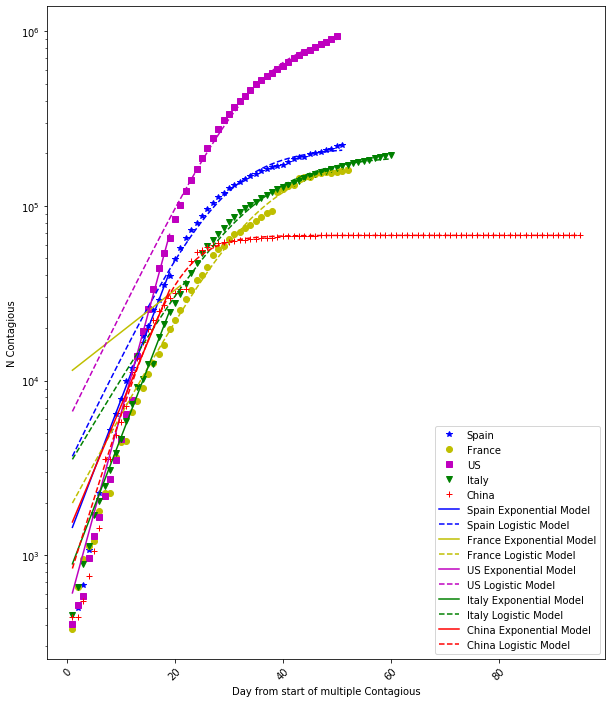

In [15]:
plot_normalized_day0(df_contag,label='Contagious')

Last amount:
Spain  22902
France  22614
US  53755
Italy  26384
China  4512
Spain Exponential fit: a=12.257, b=0.255, c=-2.458
Spain Logistic fit: a=6.070, b=29.723, c=22380.307
France Exponential fit: a=45.807, b=0.065, c=-47.850
France Logistic fit: a=5.668, b=33.973, c=23383.835
US Exponential fit: a=9.168, b=0.269, c=1.786
US Logistic fit: a=6.037, b=40.963, c=65013.336
Italy Exponential fit: a=8.738, b=0.224, c=-5.777
Italy Logistic fit: a=7.748, b=35.763, c=26342.883
China Exponential fit: a=11.917, b=0.160, c=-8.269
China Logistic fit: a=9.023, b=28.203, c=3501.258


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


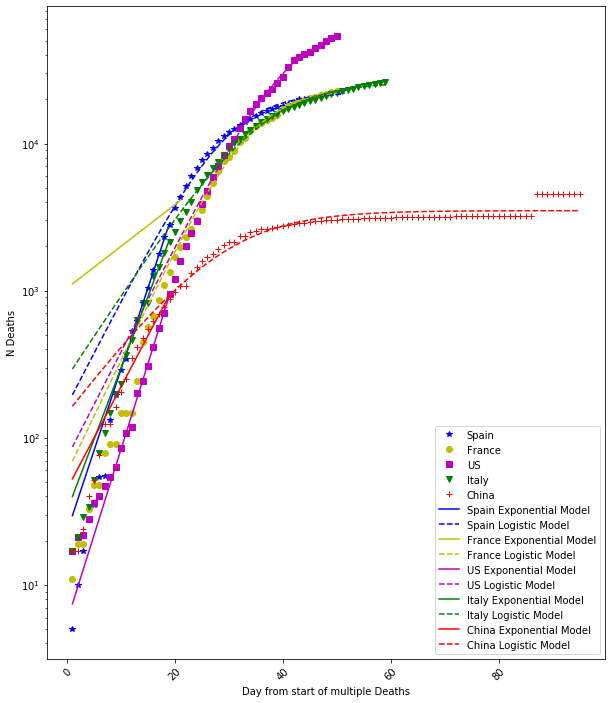

In [16]:
plot_normalized_day0(df_death,label='Deaths')

We have here fitted exponential and logistic models to the curves, and plot the above results. Let's notice than the deaths curves are much more realistic than the infected, as this depends very much on the existence of tests and different politics to measure those.

For the first time, countries such as Spain and France start to have a better logistic fit than exponential to date (31/03/2020).

## Extrapolation of the logistic model to 90 days after the first deaths/contagions

Let's use now only logistic models and assume there is going to be an inflection point of around ~25 days after the first contagions/deaths, to predict what will happen in 90 days after the first deaths / contagions.

Of course, this assumes that this inflection point is the same for all countries, and we know this will change depending on the strictness of the measurements that the different countries will take, so this is only a possible (and simple) scenario of what will happen.

In [17]:
def plot_extrapolated_logistic_model(df,label='Contagious',inflexion=25):
    
    fig = plt.figure(figsize=(10,12))
    ax = fig.add_subplot(1, 1, 1)

    
    plt.plot(df['DayStartSpain'][df['DayStartSpain']>0],df['Spain'][df['DayStartSpain']>0],'b*')
    plt.plot(df['DayStartFrance'][df['DayStartFrance']>0],df['France'][df['DayStartFrance']>0],'yo')
    plt.plot(df['DayStartUS'][df['DayStartUS']>0],df['WholeUS'][df['DayStartUS']>0],'ms')
    plt.plot(df['DayStartItaly'][df['DayStartItaly']>0],df['Italy'][df['DayStartItaly']>0],'gv')
    plt.plot(df['DayStartChina'],df['China'],'r+')

    xxPredictions = np.arange(0, 120)    
    
    xxS = np.array(df['DayStartSpain'][df['DayStartSpain']>0])
    yyS = np.array(df['Spain'][df['DayStartSpain']>0])
    popt, pcov = curve_fit(logistic_model, xxS, yyS, bounds=([1,inflexion-10,100], [10., inflexion+10, 1000000.]))       
#    popt, pcov = curve_fit(logistic_model, xxS, yyS, bounds=([1,10,100], [10., 100, 1000000.]))   
    
    plt.plot(xxPredictions, logistic_model(xxPredictions, popt[0],popt[1],popt[2]), 'b-')
    print('Spain',popt[0],popt[1],popt[2])
    print('Last expected amount 90 days before start:')
    print('Spain ',logistic_model(xxPredictions, popt[0],popt[1],popt[2])[-1])
    
    xxF = np.array(df['DayStartFrance'][df['DayStartFrance']>0])
    yyF = np.array(df['France'][df['DayStartFrance']>0])
    popt, pcov = curve_fit(logistic_model, xxF, yyF, bounds=([1,inflexion-10,100], [10., inflexion+10, 1000000.]))
#    popt, pcov = curve_fit(logistic_model, xxF, yyF, bounds=([4,1,100], [10., 100, 100000.]))
    plt.plot(xxPredictions, logistic_model(xxPredictions, popt[0],popt[1],popt[2]), 'y-')#
    print('France',popt[0],popt[1],popt[2])
    print('Last expected amount 90 days before start:')
    print('France ',logistic_model(xxPredictions, popt[0],popt[1],popt[2])[-1])
    
    xxW = np.array(df['DayStartUS'][df['DayStartUS']>0])
    yyW = np.array(df['WholeUS'][df['DayStartUS']>0])
    popt, pcov = curve_fit(logistic_model, xxW, yyW, bounds=([1,inflexion-10,100], [10., inflexion+10, 1000000.])) 
#    popt, pcov = curve_fit(logistic_model, xxW, yyW, bounds=([4,1,100], [10.,100, 1000000.])) 
    plt.plot(xxPredictions, logistic_model(xxPredictions, *popt), 'm-')#
    print('US',popt[0],popt[1],popt[2])
    print('Last expected amount 90 days before start:')
    print('US',logistic_model(xxPredictions, popt[0],popt[1],popt[2])[-1])
    
    xxI = np.array(df['DayStartItaly'][df['DayStartItaly']>0])
    yyI = np.array(df['Italy'][df['DayStartItaly']>0])
    popt, pcov = curve_fit(logistic_model, xxI, yyI, bounds=([1,inflexion-10,100], [10., inflexion+10, 1000000.]))
#    popt, pcov = curve_fit(logistic_model, xxI, yyI, bounds=([4,1,100], [10., 100, 1000000.]))
    plt.plot(xxPredictions, logistic_model(xxPredictions, popt[0],popt[1],popt[2]), 'g-')#
    print('Italy',popt[0],popt[1],popt[2])
    print('Last expected amount 90 days before start:')
    print('Italy ',logistic_model(xxPredictions, popt[0],popt[1],popt[2])[-1])
        
    xxC = np.array(df['DayStartChina'])
    yyC = np.array(df['China'])
    popt, pcov = curve_fit(logistic_model, xxC, yyC, bounds=([1,10,100], [10., 100, 100000.]))
#    popt, pcov = curve_fit(logistic_model, xxC, yyC, bounds=([4,1,100], [10., 100, 100000.]))
    plt.plot(xxPredictions, logistic_model(xxPredictions, popt[0],popt[1],popt[2]), 'r-')#
    print('China',popt[0],popt[1],popt[2])
    print('Last expected amount 90 days before start:')
    print('China ',logistic_model(xxPredictions, popt[0],popt[1],popt[2])[-1])

    
    ax.set_yscale('log')
    plt.xticks(rotation=45)
    plt.legend(['Spain','France','US','Italy','China','Spain Logistic Model','France Logistic Model',
                'US Logistic Model','Italy Logistic Model', 'China Logistic Model'])
    plt.xlabel('Day from start of multiple '+label)
    plt.ylabel('N '+label)
    plt.show()

Spain 6.7448431543685965 28.338874550678497 215676.0579345843
Last expected amount 90 days before start:
Spain  215675.74445326338
France 7.599993611293825 35.32717733912989 183972.78382246458
Last expected amount 90 days before start:
France  183969.74054397273
US 6.865404473354568 35.34129882710156 996198.9262617123
Last expected amount 90 days before start:
US 996193.8419927211
Italy 8.253216700689345 33.888589866529216 193772.0930933876
Last expected amount 90 days before start:
Italy  193765.65719735567
China 4.271072476610995 19.70786813641117 67816.41091499002
Last expected amount 90 days before start:
China  67816.41090955707


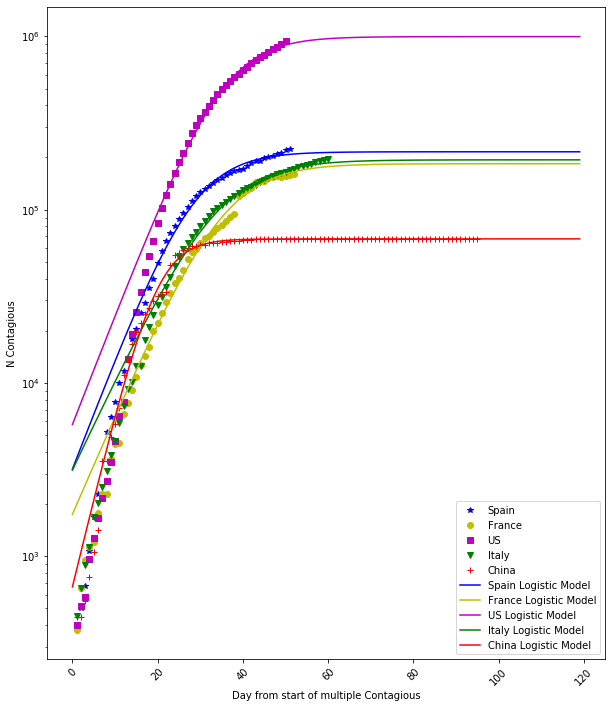

In [18]:
plot_extrapolated_logistic_model(df_contag,label='Contagious',inflexion=28)

Spain 6.070411695949128 29.723494483587707 22380.305533714378
Last expected amount 90 days before start:
Spain  22380.296355224316
France 5.668056688961252 33.97283247645105 23383.841278360993
Last expected amount 90 days before start:
France  23383.834133159813
US 4.940800352584119 37.99999999999999 53604.70189182534
Last expected amount 90 days before start:
US 53604.69782426977
Italy 7.747983082329694 35.76337432122558 26342.86404184962
Last expected amount 90 days before start:
Italy  26342.295155440628
China 9.023355770488388 28.203195934319737 3501.2594784697144
Last expected amount 90 days before start:
China  3501.1101468124994


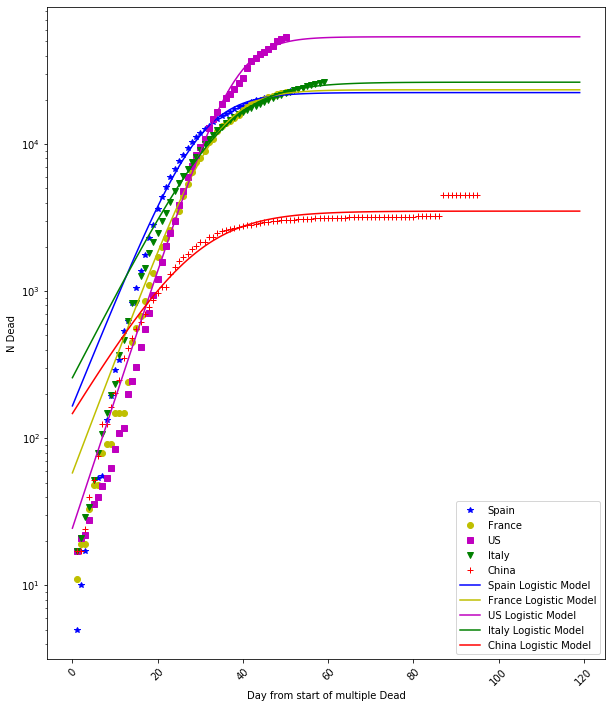

In [19]:
plot_extrapolated_logistic_model(df_death,label='Dead',inflexion=28)

I have used here, an inflexion point of 28 days for deaths, based on the data from Italy.  This might change or not, based on the different measures each country takes. Based on this, the predictions are:

- ~22000 deaths in Spain, ~ 26000 in Italy, ~23000 in France and ~54000 in the US (where the inflexion point is much higher ~38 days). In China, the official number of deaths are ~3000 (lately 4500 with new datea).
- The number of infected would be of the order of ~216.000 per Spain, 194.000 per Italy, 184.000 per France and ~997.000 for the US. China would have ~68.000. 
- Of course these numbers are based on the official number of infected and deaths but, this is very related to the different politics in terms of testing people and counting deaths due to CoronaVirus. Probably this is just a inferior limit.

## Things to do

- Add more countries
- Normalize by the population of each country / number of bed in hospitals per country.
- Try different scenarios (such as inflexion points)
- Continously update with new data (and hopefully expect that this will change!)